# Create complete network
- get all layers created so far (IRIS, centroids, roads for cars and bikes, public transport layer(s))

- connect centroids to the carbike network: 
    - combine centroids and carbike nodes into one nodes_network dataframe
    - put the combined nodes and the carbike edges into snkit
    - create a base_network with them, create a linked network
    - go back to separate carbike and centroid dataframes as needed



In [1]:
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '1'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network
crs_fr = 2154 #4326 ?
plt.rcParams['figure.figsize'] = (10, 10)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

## Get layers

### grid, boundary

In [3]:
# Get boundary of GPM (for plots)

GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

In [4]:
# Get grid and centroids
grid = pd.read_csv('data/processed/IRIS_GPM.csv').rename(columns = {'geometry' : 'cells'})

# turn into geodataframe and separate centroids (for plots)
for c in ['cells', 'centroid']:
    grid[c] = grid[c].apply(shapely.wkt.loads)
    
grid = gpd.GeoDataFrame(grid, crs = crs_fr, geometry= 'cells' )
centroids = grid.set_geometry('centroid').set_crs(crs_fr)


### roads 

In [5]:
# Get roads (car/bike)
edges_all = pd.read_csv("./data/processed/carbike_edges.csv").drop(columns = 'key')
nodes_all = pd.read_csv("./data/processed/carbike_nodes.csv")


In [6]:
# Part of Anastassia's pre-process for nodes
# Creating the column "nodetype" 
bike_nodes = set(edges_all.loc[edges_all['edgetype'] == 'bike']['u'])
nodes_all['nodetype'] = 0

for index, row in nodes_all.iterrows():
    if row["osmid"] in bike_nodes:
        nodes_all.loc[index, "nodetype"] = 'bike'
    else:
        nodes_all.loc[index, "nodetype"] = 'car'
        
# Turn into GeoDataFrame
nodes_all["geometry"] = nodes_all.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_all = gpd.GeoDataFrame(nodes_all, geometry = 'geometry', crs = 4326)


In [7]:
# Part of Anastassia's pre-process for edges 

# add edge ids (strings with "id1, id2" sorted (id1 < id2))
edges_all["edge_id"] = edges_all.apply(lambda x: str(sorted([x["u"], x["v"]])), axis = 1)

# MOD: removed oneway and length from the subset
edges_all_unique = edges_all.drop_duplicates(subset = ["osmid", "edge_id"],
                  keep = "first",
                  inplace = False,
                  ignore_index = True).copy()

# remove duplicates 
edges_all_unique = edges_all_unique.drop_duplicates(subset = ["u", "v", "osmid", "edge_id", "edgetype"], 
                          keep = "first",
                          ignore_index = True, 
                          inplace = False)

edges_all_unique_tokeep = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"]=="bike")].index
edges_all_unique_todrop = edges_all_unique[edges_all_unique.duplicated("edge_id", keep = False) & (edges_all_unique["edgetype"] == "car")].index

# MOD changed "multi" to "both"
edges_all_unique.loc[edges_all_unique_tokeep, "edgetype"] = "both"
edges_all_unique = edges_all_unique.drop(edges_all_unique_todrop)

# sort by "left" node (id1 < id2 - to control order of tuple keys in nx)
edges_all_unique["order"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.sort_values(by = "order").reset_index(drop = True)
# MOD: used "x" and "y" insteads of "orgig" and "dest"
edges_all_unique["x"] = edges_all_unique.apply(lambda x: np.min([x["u"], x["v"]]), axis = 1)
edges_all_unique["y"] = edges_all_unique.apply(lambda x: np.max([x["u"], x["v"]]), axis = 1)
edges_all_unique = edges_all_unique.drop(columns = ["order", "u", "v"]) # instead of "u" and "v",
# we will use "origin" and "destination" where osmid(origin) < osmid (destination)!


In [8]:
# # Plot
# ax = plt.axes()
# edges_all.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_all.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

## Connect carbike edges and centroids
A network is created with
- nodes = centroids and road intersections
- edges = roads

These edges and nodes are connected by creating an edge between each centroid and its nearest edge.

In [9]:
#--- Create dataframe with all carbike nodes and centroids

# Modify the centroids to be compatible with the carbike nodes
centroids_network = centroids
centroids_network = centroids_network.rename(columns = {'centroid':'geometry'}).set_geometry('geometry').to_crs(4326).drop(columns = ['NOM_COM',
                                      'CODE_IRIS',
                                      'NOM_IRIS',
                                      'cells',
                                      'osm_id'])
centroids_network['nodetype'] = 'bike'

# Create the nodes_network dataframe 
nodes_network = pd.concat([nodes_all,centroids_network])

In [10]:
#--- Creating the network 

# Nodes 
nodes = nodes_network

# Edges
edges_all_unique["geometry"] = edges_all_unique.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_all_unique = gpd.GeoDataFrame(edges_all_unique, geometry = "geometry") 
edges = gpd.GeoDataFrame(edges_all_unique, geometry = 'geometry', crs = 4326)

base_network = snkit.Network(nodes, edges)

# # plot
# ax = plt.axes()
# base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
# base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [ ]:
%%time 
#--- Link centroids to their nearest edge (takes a while)

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?

# create IDs for the new nodes and edges
with_id = snkit.network.add_topology(snkit.network.add_ids(linked))

# # plot
# ax = plt.axes()
# linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [ ]:
# Separate old nodes (centroids) from new ones (intersection between centroid and nearest edge)
new_carbike_nodes = with_id.nodes[with_id.nodes['nodetype'].isnull()]

# Separate centroids from the other nodes of this network
centroids_network = with_id.nodes[(with_id.nodes['x'].isnull()) 
                                  & (with_id.nodes['nodetype'].notnull())]

## Post-linking processing

### Nodes
- Make centroids compatible with carbike nodes
- Make the new nodes compatible with the carbike nodes
- Add the new nodes to the carbike nodes
- Process all carbike nodes (old and new)

In [ ]:
#--- Process centroids 
centroids_network = centroids_network.drop(columns = 'osmid')

# Create the x and y columns
centroids_network = centroids_network.rename(columns = {'id':'osmid'})
centroids_network['x'] = centroids_network.geometry.apply(lambda p: p.x)
centroids_network['y'] = centroids_network.geometry.apply(lambda p: p.y)

# Add attributes 
centroids_network['osmid'] = centroids_network['osmid'].str[5:].astype(int)
centroids_network['centroid'] = True
centroids_network['RER'] = False

centroids_network.tail(1)

In [ ]:
#--- Process new carbike nodes 
new_carbike_nodes = new_carbike_nodes.drop(columns = 'osmid')

# Create the x and y columns
new_carbike_nodes['x'] = new_carbike_nodes.geometry.apply(lambda p: p.x)
new_carbike_nodes['y'] = new_carbike_nodes.geometry.apply(lambda p: p.y)
new_carbike_nodes = new_carbike_nodes.rename(columns = {'id':'osmid'})

# Add attributes 
new_carbike_nodes['nodetype'] = 'bike'
new_carbike_nodes['osmid'] = new_carbike_nodes['osmid'].str[5:].astype(int)
new_carbike_nodes['centroid'] = False
new_carbike_nodes['RER'] = False

new_carbike_nodes.tail(1)

In [ ]:
# QUICK CHECK: ARE ALL IDs REALLY DIFFERENT FROM THE OSMIDs? 
centroids_minID = int(centroids_network.sort_values(by = 'osmid').head(1).osmid)
centroids_maxID = int(centroids_network.sort_values(by = 'osmid').tail(1).osmid)
new_carbike_nodes_minID = int(new_carbike_nodes.sort_values(by = 'osmid').head(1).osmid)
new_carbike_nodes_maxID = int(new_carbike_nodes.sort_values(by = 'osmid').tail(1).osmid)
nodes_all_minID = int(nodes_all.sort_values(by = 'osmid').head(1).osmid)
nodes_all_maxID = int(nodes_all.sort_values(by = 'osmid').tail(1).osmid)

print(centroids_minID, 
      centroids_maxID, 
      new_carbike_nodes_minID, 
      new_carbike_nodes_maxID,
      nodes_all_minID, 
      nodes_all_maxID) 

In [ ]:
#-- Process old carbike nodes
# Add attributes to the old carbike nodes
nodes_all['centroid'] = False
nodes_all['RER'] = False

In [ ]:
#--- Combine all nodes
nodes_carbike_complete = pd.concat([nodes_all, new_carbike_nodes, centroids_network]) 
nodes_carbike_complete = gpd.GeoDataFrame(nodes_carbike_complete, geometry = "geometry")


#--- Dealing with the nodes like we used to (Anastassia) 
# Sort values and drop duplicates 
nodes_carbike_complete = nodes_carbike_complete.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
# MOD: added centroid and RER as attributes 
nodes_carbike_complete["attr_dict"] = nodes_carbike_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

nodes_carbike_complete["osmid"] = nodes_carbike_complete["osmid"].astype(int)
nodes_carbike_complete.head(1)


### Edges
- Make new edges compatible with the old ones
    - some new edges connect with a node from the carbike network using the ID given by linked_network instead of the original osmID -> change these IDs into their osmIDs AND update this info in the edges df
    - These IDs are already absent from the nodes_carbike_complete df since it is based on the old nodes_all df and the new_nodes and centroids dfs

In [151]:
#--- Make with_id.nodes and edges workable
n = 5
with_id.edges['from_id'] = with_id.edges['from_id'].str[5:].astype(int)
with_id.edges['to_id'] = with_id.edges['to_id'].str[5:].astype(int)
with_id.nodes['id'] = with_id.nodes['id'].str[5:].astype(int)

#--- Replacing new IDs with osmIDs where necessary
# Find which original carbike nodes are part of a new edge 
oldnodes_in_newedges = with_id.nodes.loc[(with_id.nodes['osmid'].notnull()) # They have an non-null osmID (the new nodes don't have one)
                                         & (with_id.nodes['id'].isin(set(with_id.edges.to_id)) # They are part of new_edges.to_id or new_edges.from_id
                                            | with_id.nodes['id'].isin(set(with_id.edges.from_id)))]

# Changing IDs to osmIDs in with_id.edges
# Create a dictionary of ID to osmID
oldnodes_in_newedges.set_index('id',inplace=True)
id_osmid_dict = oldnodes_in_newedges.to_dict()['osmid']

# Replace IDs with osmIDs in the edges dataframe
with_id.edges['from_id'] = with_id.edges['from_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)
with_id.edges['to_id'] = with_id.edges['to_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)

#--- Fill in the edgetype for the new edges 
# Create a dictionary of nodeID to nodetype
nodes_type_df = nodes_carbike_complete
nodes_type_df.set_index('osmid', inplace = True)
nodes_type_dict = nodes_type_df.to_dict()['nodetype']

# Find the correcty column index to work with
index_edgetype = with_id.edges.columns.get_loc("edgetype")

for i, row in with_id.edges.iterrows():
    if pd.isnull(with_id.edges.iloc[i,index_edgetype]):
        # If both endnodes are of the same type, give that type to the edge
        if nodes_type_dict[row['from_id']] == nodes_type_dict[int(row['to_id'])]:
            with_id.edges.iloc[i,index_edgetype] = nodes_type_dict[int(row['to_id'])]
        # If they're not, make them a car edge 
        # Since centroids and RER stops are seen bike nodes, this should be fine
        else:
            with_id.edges.iloc[i, index_edgetype] = 'car'   

In [152]:
with_id.nodes = nodes_carbike_complete.reset_index().rename(columns = {'osmid':'id'})

<Axes: >

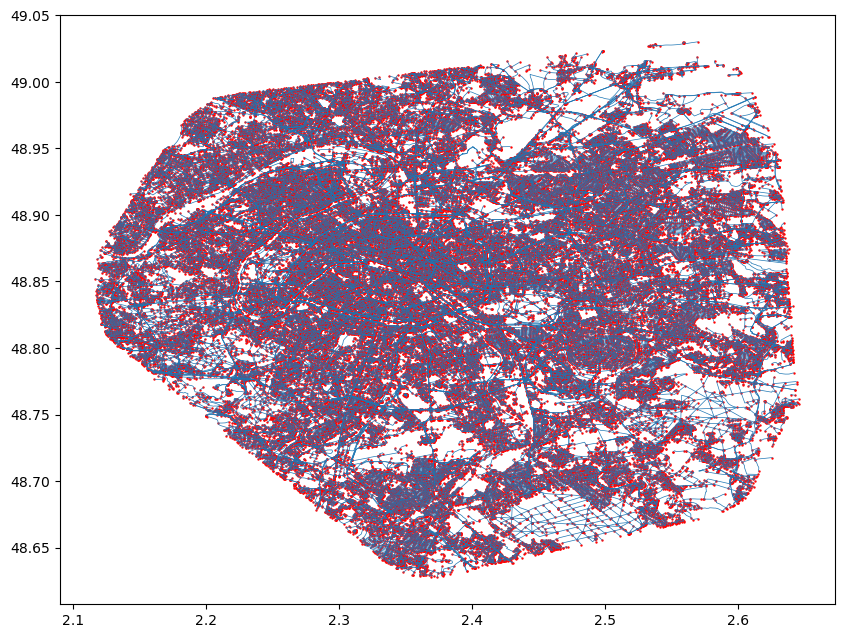

In [129]:
#--- Plot the new version for glory

ax = plt.axes()
with_id.nodes.plot(ax=ax, markersize = 0.5, color = 'r')
with_id.edges.plot(ax=ax, linewidth = 0.5)

## Creating the NetworkX Graph

In [153]:
# Create NetworkX graph of the roads (Anastassia code)

G = snkit.network.to_networkx(with_id)
# OLD CODE
# # CREATE NX OBJECTS
# # make multinetwork containing ALL edges
# car_bike_graph = nx.Graph()
# car_bike_graph.add_nodes_from(nodes_all.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

# # MOD: x and y instead of orig and dest
# car_bike_graph.add_edges_from(edges_all_unique.loc[:,["x", "y", "attr_dict"]].itertuples(index = False))

# # MOD: removed the LCC part

In [154]:
nx.shortest_path(G, 115083, 115173)

[115083,
 118057.0,
 348769224.0,
 348769218.0,
 268129107.0,
 268133515.0,
 268138879.0,
 268131466.0,
 268131465.0,
 118142.0,
 115173]

## What's next?

BUILDING THE SKELETAL NETWORK --April--
- finish cleaning up edges/nodes for carbike after linking them with the centroids
    - edges need
        - ~~to have info on the travel mode (car/bike/public transport)~~
        - weight = travel time for the relevant transport mode
        - ~~origin and destination node IDs~~
- create separate edges for car and bike travel
- add restriction on how to travel (either only bike or only car, not both)
- add RER
- send visuals and stuff to Anastassia and Trivik
GOAL: I can pick two centroids and find the shortest path, which is all walk, all bike, or walk/bike to station then walk 


SOCIAL STUFF -- second midterm (May 22nd)--
- define needed data for POIs and people 
- find data for POIs and people
- add all of it to centroids
- find/define OD matrix
GOAL: I can pick one pop and one POI and find the shortest path

OPTIMISATION STUFF (June)
- find algorithm
- modify network to allow for optimisation
- do whatever it takes to get stuff to run
- first results!! 
